In [30]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import datacleaner
import datetime
imp.reload(datacleaner)

from datacleaner import *

In [70]:
np.random.seed(1)
tf.keras.backend.clear_session()

bd = pd.read_csv(r"USAccDeaths.csv")
bd.pop("Unnamed: 0")
bd

,time,value
0,1973.000000,9007
1,1973.083333,8106
2,1973.166667,8928
3,1973.250000,9137
4,1973.333333,10017
...,...,...
67,1978.583333,9827
68,1978.666667,9110
69,1978.750000,9070
70,1978.833333,8633


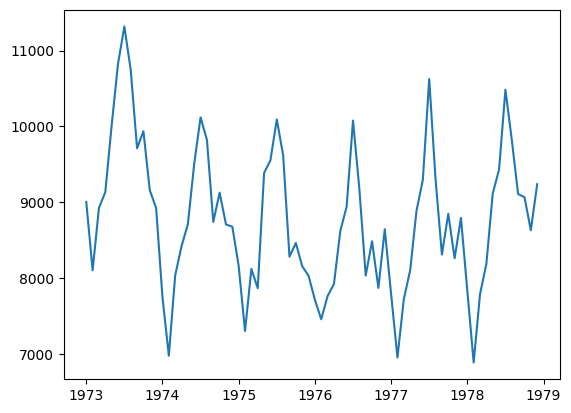

array([[-1.        , -0.0440678 ],
       [-0.97183099, -0.45129944],
       [-0.94366197, -0.07977401],
       [-0.91549296,  0.01468927],
       [-0.88732394,  0.41242938],
       [-0.85915493,  0.7780791 ],
       [-0.83098592,  1.        ],
       [-0.8028169 ,  0.74101695],
       [-0.77464789,  0.27502825],
       [-0.74647887,  0.37672316],
       [-0.71830986,  0.02553672],
       [-0.69014085, -0.08022599],
       [-0.66197183, -0.61220339],
       [-0.63380282, -0.95977401],
       [-0.6056338 , -0.4820339 ],
       [-0.57746479, -0.30847458],
       [-0.54929577, -0.17649718],
       [-0.52112676,  0.18418079],
       [-0.49295775,  0.45898305],
       [-0.46478873,  0.32474576],
       [-0.43661972, -0.16338983],
       [-0.4084507 ,  0.01107345],
       [-0.38028169, -0.17830508],
       [-0.35211268, -0.19186441],
       [-0.32394366, -0.4259887 ],
       [-0.29577465, -0.81288136],
       [-0.26760563, -0.44316384],
       [-0.23943662, -0.5579661 ],
       [-0.21126761,

In [71]:
plt.plot(bd["time"],bd["value"])
plt.show()
bd=MinMaxScaler(feature_range=(-1,1)).fit_transform(bd.values)
bd


In [76]:
def df_to_X_y(df, window_size=5):
    X = []
    y = []
    for i in range(len(df) - window_size):
        row = df[i:i + window_size]
        X.append(row)
        label = df[i + window_size][-1]  # Última coluna contém a variável de destino (incidentes)
        y.append(label)
    return np.array(X), np.array(y)

In [77]:
WINDOW_SIZE = 1
X1, y1 = df_to_X_y(bd, WINDOW_SIZE)
X1.shape, y1.shape

((71, 1, 2), (71,))

In [78]:
X_train1, y_train1 = X1[:55], y1[:55]
X_val1, y_val1 = X1[55:60], y1[55:60]
X_test1, y_test1 = X1[60:], y1[60:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((55, 1, 2), (55,), (5, 1, 2), (5,), (11, 1, 2), (11,))

In [79]:
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model2 = Sequential()
model2.add(InputLayer((1, 2)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________


In [80]:
cp1 = ModelCheckpoint('modelNossoLSTM/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [81]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp1])

Epoch 1/100
1/2 [==============>...............] - ETA: 1s - loss: 0.1659 - root_mean_squared_error: 0.4074

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 5s 4s/step - loss: 0.2215 - root_mean_squared_error: 0.4707 - val_loss: 0.1301 - val_root_mean_squared_error: 0.3606
Epoch 2/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2407 - root_mean_squared_error: 0.4906

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2211 - root_mean_squared_error: 0.4703 - val_loss: 0.1298 - val_root_mean_squared_error: 0.3603
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2304 - root_mean_squared_error: 0.4800

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2207 - root_mean_squared_error: 0.4698 - val_loss: 0.1296 - val_root_mean_squared_error: 0.3600
Epoch 4/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2477 - root_mean_squared_error: 0.4977

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2203 - root_mean_squared_error: 0.4694 - val_loss: 0.1294 - val_root_mean_squared_error: 0.3597
Epoch 5/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2462 - root_mean_squared_error: 0.4962

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2199 - root_mean_squared_error: 0.4689 - val_loss: 0.1291 - val_root_mean_squared_error: 0.3593
Epoch 6/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2139 - root_mean_squared_error: 0.4625

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2195 - root_mean_squared_error: 0.4685 - val_loss: 0.1289 - val_root_mean_squared_error: 0.3590
Epoch 7/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2029 - root_mean_squared_error: 0.4505

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2191 - root_mean_squared_error: 0.4680 - val_loss: 0.1287 - val_root_mean_squared_error: 0.3587
Epoch 8/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1771 - root_mean_squared_error: 0.4208

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2186 - root_mean_squared_error: 0.4676 - val_loss: 0.1284 - val_root_mean_squared_error: 0.3584
Epoch 9/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2402 - root_mean_squared_error: 0.4901

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2183 - root_mean_squared_error: 0.4672 - val_loss: 0.1282 - val_root_mean_squared_error: 0.3581
Epoch 10/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1887 - root_mean_squared_error: 0.4344

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2179 - root_mean_squared_error: 0.4668 - val_loss: 0.1280 - val_root_mean_squared_error: 0.3578
Epoch 11/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2184 - root_mean_squared_error: 0.4674

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2175 - root_mean_squared_error: 0.4664 - val_loss: 0.1278 - val_root_mean_squared_error: 0.3575
Epoch 12/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2189 - root_mean_squared_error: 0.4679

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2171 - root_mean_squared_error: 0.4660 - val_loss: 0.1276 - val_root_mean_squared_error: 0.3572
Epoch 13/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2151 - root_mean_squared_error: 0.4638

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2167 - root_mean_squared_error: 0.4656 - val_loss: 0.1274 - val_root_mean_squared_error: 0.3569
Epoch 14/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1906 - root_mean_squared_error: 0.4366

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2164 - root_mean_squared_error: 0.4652 - val_loss: 0.1272 - val_root_mean_squared_error: 0.3567
Epoch 15/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1886 - root_mean_squared_error: 0.4342

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2160 - root_mean_squared_error: 0.4648 - val_loss: 0.1270 - val_root_mean_squared_error: 0.3564
Epoch 16/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1785 - root_mean_squared_error: 0.4225

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2157 - root_mean_squared_error: 0.4644 - val_loss: 0.1268 - val_root_mean_squared_error: 0.3561
Epoch 17/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2777 - root_mean_squared_error: 0.5270

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2154 - root_mean_squared_error: 0.4641 - val_loss: 0.1266 - val_root_mean_squared_error: 0.3558
Epoch 18/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2190 - root_mean_squared_error: 0.4680

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2150 - root_mean_squared_error: 0.4637 - val_loss: 0.1264 - val_root_mean_squared_error: 0.3555
Epoch 19/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1879 - root_mean_squared_error: 0.4335

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2147 - root_mean_squared_error: 0.4634 - val_loss: 0.1262 - val_root_mean_squared_error: 0.3552
Epoch 20/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1683 - root_mean_squared_error: 0.4102

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2144 - root_mean_squared_error: 0.4630 - val_loss: 0.1260 - val_root_mean_squared_error: 0.3549
Epoch 21/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2082 - root_mean_squared_error: 0.4563

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2141 - root_mean_squared_error: 0.4627 - val_loss: 0.1258 - val_root_mean_squared_error: 0.3546
Epoch 22/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2122 - root_mean_squared_error: 0.4606

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2137 - root_mean_squared_error: 0.4623 - val_loss: 0.1256 - val_root_mean_squared_error: 0.3544
Epoch 23/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2154 - root_mean_squared_error: 0.4641

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2134 - root_mean_squared_error: 0.4620 - val_loss: 0.1254 - val_root_mean_squared_error: 0.3541
Epoch 24/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1964 - root_mean_squared_error: 0.4432

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2131 - root_mean_squared_error: 0.4616 - val_loss: 0.1252 - val_root_mean_squared_error: 0.3538
Epoch 25/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2016 - root_mean_squared_error: 0.4490

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2128 - root_mean_squared_error: 0.4613 - val_loss: 0.1250 - val_root_mean_squared_error: 0.3535
Epoch 26/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2230 - root_mean_squared_error: 0.4722

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2125 - root_mean_squared_error: 0.4610 - val_loss: 0.1248 - val_root_mean_squared_error: 0.3532
Epoch 27/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2270 - root_mean_squared_error: 0.4764

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2122 - root_mean_squared_error: 0.4607 - val_loss: 0.1246 - val_root_mean_squared_error: 0.3530
Epoch 28/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2120 - root_mean_squared_error: 0.4604

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2119 - root_mean_squared_error: 0.4604 - val_loss: 0.1244 - val_root_mean_squared_error: 0.3527
Epoch 29/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2293 - root_mean_squared_error: 0.4788

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2116 - root_mean_squared_error: 0.4601 - val_loss: 0.1242 - val_root_mean_squared_error: 0.3524
Epoch 30/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1966 - root_mean_squared_error: 0.4434

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2113 - root_mean_squared_error: 0.4597 - val_loss: 0.1240 - val_root_mean_squared_error: 0.3521
Epoch 31/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2116 - root_mean_squared_error: 0.4600

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2110 - root_mean_squared_error: 0.4594 - val_loss: 0.1238 - val_root_mean_squared_error: 0.3518
Epoch 32/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2221 - root_mean_squared_error: 0.4713

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2108 - root_mean_squared_error: 0.4591 - val_loss: 0.1236 - val_root_mean_squared_error: 0.3516
Epoch 33/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2392 - root_mean_squared_error: 0.4890

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2105 - root_mean_squared_error: 0.4588 - val_loss: 0.1234 - val_root_mean_squared_error: 0.3513
Epoch 34/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2110 - root_mean_squared_error: 0.4593

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2102 - root_mean_squared_error: 0.4585 - val_loss: 0.1232 - val_root_mean_squared_error: 0.3510
Epoch 35/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2388 - root_mean_squared_error: 0.4886

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2099 - root_mean_squared_error: 0.4581 - val_loss: 0.1230 - val_root_mean_squared_error: 0.3507
Epoch 36/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2348 - root_mean_squared_error: 0.4845

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2096 - root_mean_squared_error: 0.4578 - val_loss: 0.1228 - val_root_mean_squared_error: 0.3505
Epoch 37/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2210 - root_mean_squared_error: 0.4701

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2093 - root_mean_squared_error: 0.4575 - val_loss: 0.1226 - val_root_mean_squared_error: 0.3502
Epoch 38/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2297 - root_mean_squared_error: 0.4793

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2091 - root_mean_squared_error: 0.4572 - val_loss: 0.1224 - val_root_mean_squared_error: 0.3499
Epoch 39/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2143 - root_mean_squared_error: 0.4629

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2088 - root_mean_squared_error: 0.4569 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3496
Epoch 40/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1712 - root_mean_squared_error: 0.4138

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2085 - root_mean_squared_error: 0.4566 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3493
Epoch 41/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1748 - root_mean_squared_error: 0.4180

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2082 - root_mean_squared_error: 0.4563 - val_loss: 0.1218 - val_root_mean_squared_error: 0.3490
Epoch 42/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2570 - root_mean_squared_error: 0.5070

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2080 - root_mean_squared_error: 0.4560 - val_loss: 0.1216 - val_root_mean_squared_error: 0.3488
Epoch 43/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1686 - root_mean_squared_error: 0.4107

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2077 - root_mean_squared_error: 0.4557 - val_loss: 0.1214 - val_root_mean_squared_error: 0.3485
Epoch 44/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2107 - root_mean_squared_error: 0.4590

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2074 - root_mean_squared_error: 0.4554 - val_loss: 0.1212 - val_root_mean_squared_error: 0.3481
Epoch 45/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2160 - root_mean_squared_error: 0.4648

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2072 - root_mean_squared_error: 0.4552 - val_loss: 0.1210 - val_root_mean_squared_error: 0.3479
Epoch 46/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1980 - root_mean_squared_error: 0.4450

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2069 - root_mean_squared_error: 0.4548 - val_loss: 0.1208 - val_root_mean_squared_error: 0.3476
Epoch 47/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1787 - root_mean_squared_error: 0.4228

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2066 - root_mean_squared_error: 0.4545 - val_loss: 0.1206 - val_root_mean_squared_error: 0.3473
Epoch 48/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1889 - root_mean_squared_error: 0.4346

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2063 - root_mean_squared_error: 0.4542 - val_loss: 0.1204 - val_root_mean_squared_error: 0.3470
Epoch 49/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2158 - root_mean_squared_error: 0.4646

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2061 - root_mean_squared_error: 0.4539 - val_loss: 0.1202 - val_root_mean_squared_error: 0.3467
Epoch 50/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2104 - root_mean_squared_error: 0.4587

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2058 - root_mean_squared_error: 0.4536 - val_loss: 0.1200 - val_root_mean_squared_error: 0.3464
Epoch 51/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2064 - root_mean_squared_error: 0.4543

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2055 - root_mean_squared_error: 0.4533 - val_loss: 0.1198 - val_root_mean_squared_error: 0.3461
Epoch 52/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1990 - root_mean_squared_error: 0.4461

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2053 - root_mean_squared_error: 0.4531 - val_loss: 0.1196 - val_root_mean_squared_error: 0.3458
Epoch 53/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2081 - root_mean_squared_error: 0.4562

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2050 - root_mean_squared_error: 0.4527 - val_loss: 0.1194 - val_root_mean_squared_error: 0.3455
Epoch 54/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1501 - root_mean_squared_error: 0.3875

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2047 - root_mean_squared_error: 0.4524 - val_loss: 0.1191 - val_root_mean_squared_error: 0.3452
Epoch 55/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2165 - root_mean_squared_error: 0.4653

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2045 - root_mean_squared_error: 0.4522 - val_loss: 0.1189 - val_root_mean_squared_error: 0.3449
Epoch 56/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2371 - root_mean_squared_error: 0.4869

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2042 - root_mean_squared_error: 0.4518 - val_loss: 0.1187 - val_root_mean_squared_error: 0.3446
Epoch 57/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1954 - root_mean_squared_error: 0.4421

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2039 - root_mean_squared_error: 0.4515 - val_loss: 0.1185 - val_root_mean_squared_error: 0.3443
Epoch 58/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2106 - root_mean_squared_error: 0.4589

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2037 - root_mean_squared_error: 0.4513 - val_loss: 0.1183 - val_root_mean_squared_error: 0.3440
Epoch 59/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2327 - root_mean_squared_error: 0.4824

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2034 - root_mean_squared_error: 0.4510 - val_loss: 0.1181 - val_root_mean_squared_error: 0.3437
Epoch 60/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2125 - root_mean_squared_error: 0.4610

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2031 - root_mean_squared_error: 0.4507 - val_loss: 0.1179 - val_root_mean_squared_error: 0.3434
Epoch 61/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1660 - root_mean_squared_error: 0.4074

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2028 - root_mean_squared_error: 0.4504 - val_loss: 0.1177 - val_root_mean_squared_error: 0.3431
Epoch 62/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2390 - root_mean_squared_error: 0.4889

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2026 - root_mean_squared_error: 0.4501 - val_loss: 0.1175 - val_root_mean_squared_error: 0.3428
Epoch 63/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2190 - root_mean_squared_error: 0.4680

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2023 - root_mean_squared_error: 0.4498 - val_loss: 0.1173 - val_root_mean_squared_error: 0.3425
Epoch 64/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1878 - root_mean_squared_error: 0.4333

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2021 - root_mean_squared_error: 0.4495 - val_loss: 0.1171 - val_root_mean_squared_error: 0.3422
Epoch 65/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2245 - root_mean_squared_error: 0.4739

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2018 - root_mean_squared_error: 0.4493 - val_loss: 0.1169 - val_root_mean_squared_error: 0.3419
Epoch 66/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2195 - root_mean_squared_error: 0.4685

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2016 - root_mean_squared_error: 0.4490 - val_loss: 0.1167 - val_root_mean_squared_error: 0.3416
Epoch 67/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1503 - root_mean_squared_error: 0.3877

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2013 - root_mean_squared_error: 0.4487 - val_loss: 0.1164 - val_root_mean_squared_error: 0.3412
Epoch 68/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1741 - root_mean_squared_error: 0.4173

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2011 - root_mean_squared_error: 0.4484 - val_loss: 0.1162 - val_root_mean_squared_error: 0.3409
Epoch 69/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1460 - root_mean_squared_error: 0.3821

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2008 - root_mean_squared_error: 0.4481 - val_loss: 0.1160 - val_root_mean_squared_error: 0.3406
Epoch 70/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1728 - root_mean_squared_error: 0.4157

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2006 - root_mean_squared_error: 0.4479 - val_loss: 0.1158 - val_root_mean_squared_error: 0.3403
Epoch 71/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1732 - root_mean_squared_error: 0.4162

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2003 - root_mean_squared_error: 0.4476 - val_loss: 0.1157 - val_root_mean_squared_error: 0.3401
Epoch 72/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2321 - root_mean_squared_error: 0.4818

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.2001 - root_mean_squared_error: 0.4473 - val_loss: 0.1155 - val_root_mean_squared_error: 0.3398
Epoch 73/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2174 - root_mean_squared_error: 0.4663

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1998 - root_mean_squared_error: 0.4470 - val_loss: 0.1152 - val_root_mean_squared_error: 0.3395
Epoch 74/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1694 - root_mean_squared_error: 0.4116

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1996 - root_mean_squared_error: 0.4467 - val_loss: 0.1150 - val_root_mean_squared_error: 0.3392
Epoch 75/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2259 - root_mean_squared_error: 0.4753

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1993 - root_mean_squared_error: 0.4465 - val_loss: 0.1148 - val_root_mean_squared_error: 0.3389
Epoch 76/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1619 - root_mean_squared_error: 0.4023

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1991 - root_mean_squared_error: 0.4462 - val_loss: 0.1146 - val_root_mean_squared_error: 0.3386
Epoch 77/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1975 - root_mean_squared_error: 0.4444

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1988 - root_mean_squared_error: 0.4459 - val_loss: 0.1144 - val_root_mean_squared_error: 0.3383
Epoch 78/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1677 - root_mean_squared_error: 0.4095

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1986 - root_mean_squared_error: 0.4456 - val_loss: 0.1142 - val_root_mean_squared_error: 0.3380
Epoch 79/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1846 - root_mean_squared_error: 0.4297

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1983 - root_mean_squared_error: 0.4453 - val_loss: 0.1140 - val_root_mean_squared_error: 0.3377
Epoch 80/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1620 - root_mean_squared_error: 0.4025

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1981 - root_mean_squared_error: 0.4451 - val_loss: 0.1138 - val_root_mean_squared_error: 0.3374
Epoch 81/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1965 - root_mean_squared_error: 0.4433

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1978 - root_mean_squared_error: 0.4448 - val_loss: 0.1136 - val_root_mean_squared_error: 0.3371
Epoch 82/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2627 - root_mean_squared_error: 0.5125

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1976 - root_mean_squared_error: 0.4445 - val_loss: 0.1134 - val_root_mean_squared_error: 0.3368
Epoch 83/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2036 - root_mean_squared_error: 0.4512

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1973 - root_mean_squared_error: 0.4442 - val_loss: 0.1132 - val_root_mean_squared_error: 0.3365
Epoch 84/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2080 - root_mean_squared_error: 0.4561

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1971 - root_mean_squared_error: 0.4440 - val_loss: 0.1130 - val_root_mean_squared_error: 0.3362
Epoch 85/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1753 - root_mean_squared_error: 0.4187

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1968 - root_mean_squared_error: 0.4437 - val_loss: 0.1128 - val_root_mean_squared_error: 0.3359
Epoch 86/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1967 - root_mean_squared_error: 0.4435

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1966 - root_mean_squared_error: 0.4434 - val_loss: 0.1126 - val_root_mean_squared_error: 0.3356
Epoch 87/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1825 - root_mean_squared_error: 0.4272

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1964 - root_mean_squared_error: 0.4431 - val_loss: 0.1124 - val_root_mean_squared_error: 0.3353
Epoch 88/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1622 - root_mean_squared_error: 0.4028

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1961 - root_mean_squared_error: 0.4428 - val_loss: 0.1123 - val_root_mean_squared_error: 0.3351
Epoch 89/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1980 - root_mean_squared_error: 0.4449

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1959 - root_mean_squared_error: 0.4426 - val_loss: 0.1121 - val_root_mean_squared_error: 0.3348
Epoch 90/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1991 - root_mean_squared_error: 0.4462

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1956 - root_mean_squared_error: 0.4423 - val_loss: 0.1119 - val_root_mean_squared_error: 0.3345
Epoch 91/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1748 - root_mean_squared_error: 0.4181

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1954 - root_mean_squared_error: 0.4420 - val_loss: 0.1117 - val_root_mean_squared_error: 0.3342
Epoch 92/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2067 - root_mean_squared_error: 0.4547

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1951 - root_mean_squared_error: 0.4417 - val_loss: 0.1115 - val_root_mean_squared_error: 0.3339
Epoch 93/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2324 - root_mean_squared_error: 0.4821

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1949 - root_mean_squared_error: 0.4415 - val_loss: 0.1113 - val_root_mean_squared_error: 0.3336
Epoch 94/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2321 - root_mean_squared_error: 0.4817

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1946 - root_mean_squared_error: 0.4412 - val_loss: 0.1111 - val_root_mean_squared_error: 0.3333
Epoch 95/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2382 - root_mean_squared_error: 0.4880

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1944 - root_mean_squared_error: 0.4409 - val_loss: 0.1109 - val_root_mean_squared_error: 0.3330
Epoch 96/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2073 - root_mean_squared_error: 0.4553

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1942 - root_mean_squared_error: 0.4406 - val_loss: 0.1107 - val_root_mean_squared_error: 0.3327
Epoch 97/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2392 - root_mean_squared_error: 0.4891

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1939 - root_mean_squared_error: 0.4404 - val_loss: 0.1105 - val_root_mean_squared_error: 0.3324
Epoch 98/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2040 - root_mean_squared_error: 0.4516

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1937 - root_mean_squared_error: 0.4401 - val_loss: 0.1103 - val_root_mean_squared_error: 0.3321
Epoch 99/100
1/2 [==============>...............] - ETA: 0s - loss: 0.2260 - root_mean_squared_error: 0.4754

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1934 - root_mean_squared_error: 0.4398 - val_loss: 0.1101 - val_root_mean_squared_error: 0.3318
Epoch 100/100
1/2 [==============>...............] - ETA: 0s - loss: 0.1988 - root_mean_squared_error: 0.4459

INFO:tensorflow:Assets written to: modelNossoLSTM\assets


INFO:tensorflow:Assets written to: modelNossoLSTM\assets


2/2 [==============================] - 3s 3s/step - loss: 0.1932 - root_mean_squared_error: 0.4395 - val_loss: 0.1099 - val_root_mean_squared_error: 0.3315


In [82]:
from tensorflow.keras.models import load_model
model2 = load_model('modelNossoLSTM/')

In [83]:
train_predictions = model2.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

2/2 [==============================] - 0s 2ms/step


,Train Predictions,Actuals
0,0.000911,-0.451299
1,-0.034024,-0.079774
2,-0.003441,0.014689
3,0.003899,0.412429
4,0.037111,0.778079
5,0.064244,1.000000
6,0.076288,0.741017
7,0.060310,0.275028
8,0.022566,0.376723
9,0.030504,0.025537


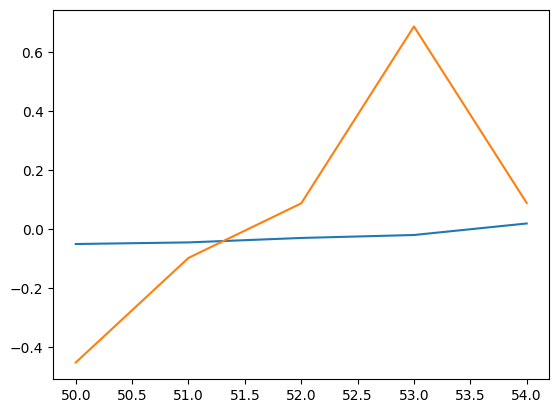

In [84]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [85]:
val_predictions = model2.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

1/1 [==============================] - 0s 17ms/step


,Val Predictions,Actuals
0,-0.018691,-0.357288
1,-0.038697,-0.115028
2,-0.028777,-0.379435
3,-0.038583,-0.139435
4,-0.029334,-0.573333


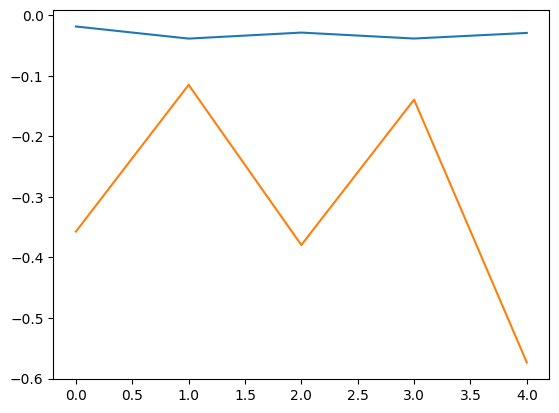

In [86]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [39]:
test_predictions = model2.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

1/1 [==============================] - 0s 334ms/step


,Test Predictions,Actuals
0,-0.003895,-1.000000
1,-0.005635,-0.593672
2,-0.003986,-0.412429
3,-0.003147,0.004746
4,0.000238,0.148927
5,0.007673,0.623503
6,0.031866,0.326554
7,0.016708,0.002486
8,0.000091,-0.015593
9,-0.000606,-0.213107


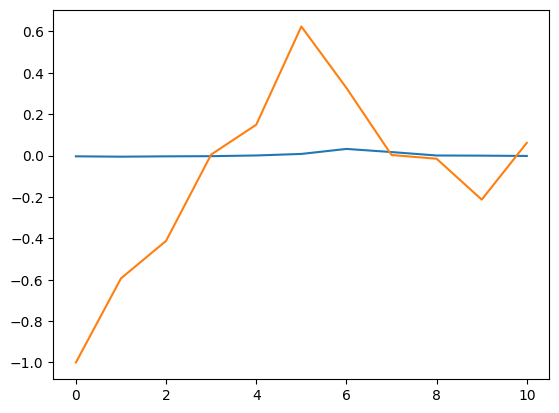

In [40]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [41]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

1/1 [==============================] - 0s 20ms/step


(    Predictions   Actuals
 0     -0.003895 -1.000000
 1     -0.005635 -0.593672
 2     -0.003986 -0.412429
 3     -0.003147  0.004746
 4      0.000238  0.148927
 5      0.007673  0.623503
 6      0.031866  0.326554
 7      0.016708  0.002486
 8      0.000091 -0.015593
 9     -0.000606 -0.213107
 10    -0.002149  0.061243,
 0.18570190547503432)

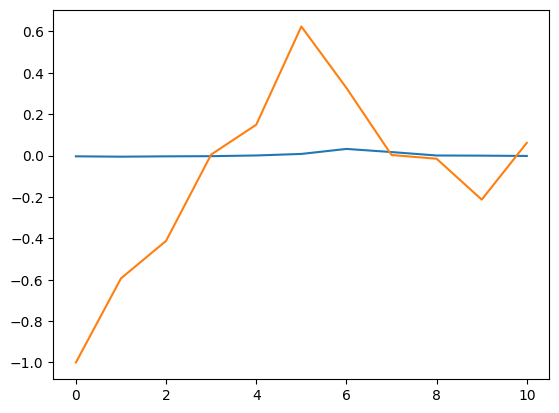

In [42]:
plot_predictions1(model2, X_test1, y_test1)